# Multiclass Clasification of Covid-19/Normal/Pneumonia's X-Rays with VGG16

## UCSP - Final Assessment - Diploma Data Science

Integrantes:
- Castañón Vilca, Joaquín Antoni
- Choque Huaylla, Diego Alonso

In the present notebook, we try to develop a classficator of Covid-19, Normal and Pneumonia's chest X-Rays, like a multiclass classificator with VGG16 and tensorflow with the use of GPU's Kaggle.
All the analysis it's just for educational purposes.
So let's start! :)

<p>Installing new libraries
    </p>

In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=e66803f3f067a296de632eff1d11b08add1fe32cdcd705c177a92baeecddf12c
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<p>Importing all the libraries which are useful for the classfication
    </p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import shutil
import random
import cv2
import argparse
import os

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100


Found GPU at: /device:GPU:0


In [4]:
dataset_path = './dataset'

In [5]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p dataset/pneumonia
mkdir -p dataset/new

In [6]:
covid_19_path = "../input/covid-chest-xray"
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

## EDA of COVID Data Set

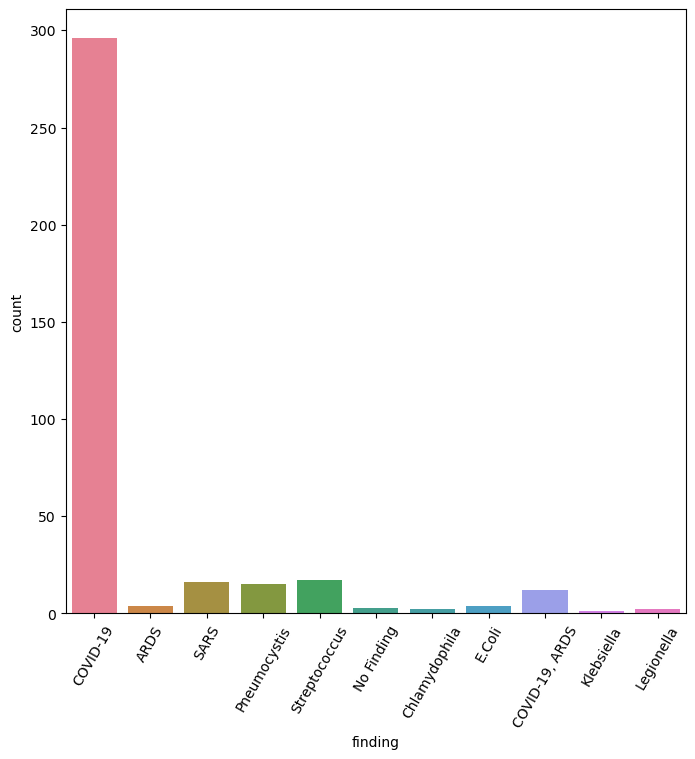

In [7]:
eda = pd.read_csv('../input/covid-chest-xray/metadata.csv')


sns.countplot(x = 'finding', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.show()

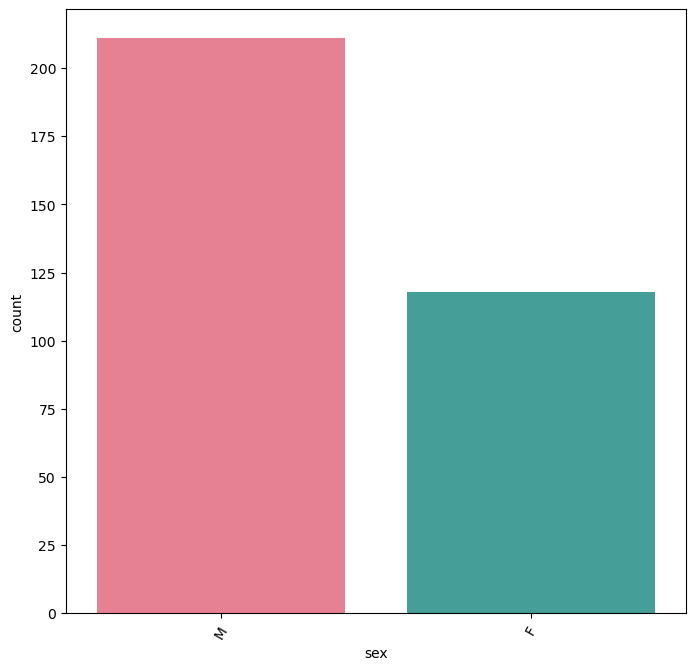

In [8]:
sns.countplot(x = 'sex', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.show()

## Creating Dataset

In [9]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_19_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_19_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [10]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
samples = 146

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [11]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "PNEUMONIA"])
imagePaths = list(paths.list_images(basePath))
samples = 146

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## X-ray show

In [12]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))
pneumonia_images = list(paths.list_images(f"{dataset_path}/pneumonia"))


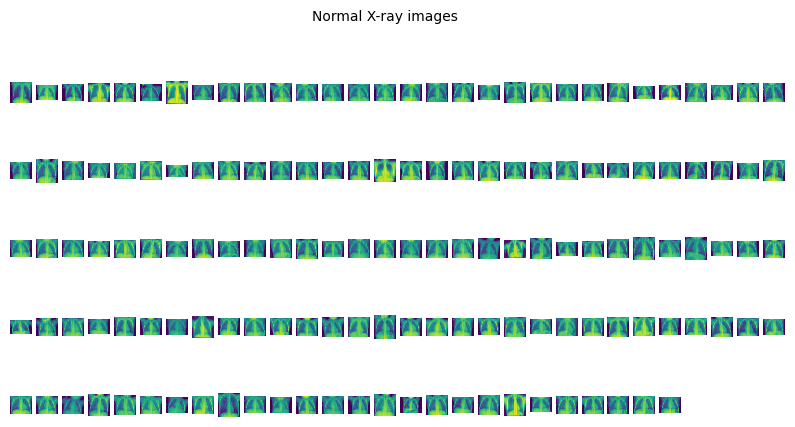

In [13]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

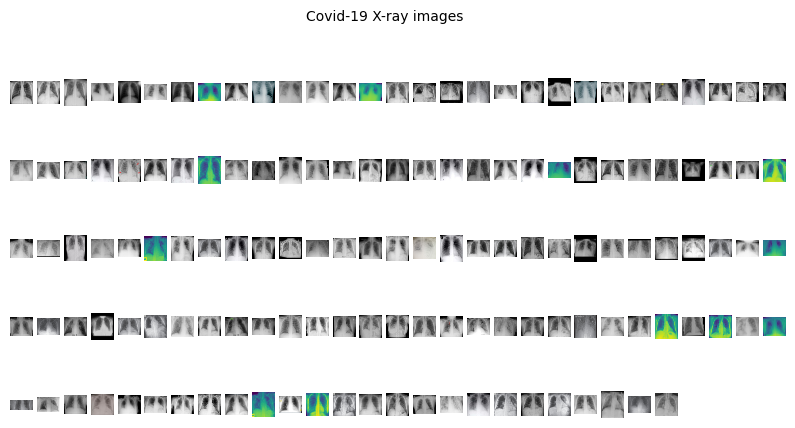

In [14]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

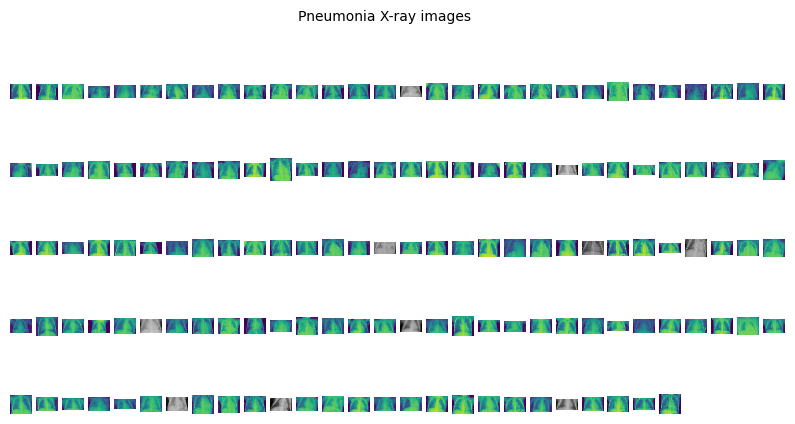

In [15]:
plots_from_files(pneumonia_images, rows=5, maintitle="Pneumonia X-ray images")

## Data Preprocesing

In [16]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

In [17]:
# lets take the labels of each image in the directory to make a classfication
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)
print("[INFO] Images successfully loaded")

[INFO] loading images...
[INFO] Images successfully loaded


In [18]:
# Now we will create a One-Hot encoding to the list of labels to make the classfication
# integer encode
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
labels = to_categorical(labels)


# Split the data into training and testing using the 80% of training and 20% to testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, stratify = labels,random_state = 42)


# Set the image augmentation of the training data
trainAug = ImageDataGenerator(rotation_range= 15, fill_mode='nearest')


## Making the model VGG16

In [19]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = base_model.output
headmodel = AveragePooling2D(pool_size =(4, 4))(headmodel)
headmodel = Flatten(name ='Flatten')(headmodel)
headmodel = Dense(64, activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = base_model.input, outputs = headmodel)

for layers in base_model.layers:
    layers.trainable = False


opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])


58892288/58889256 [==============================] - 0s 0us/step


In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [21]:
# training the model with gpu or cpu, it depends:

with tf.device('/gpu:0'):
    print("Training the model with gpu . . .")
    training = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=100)

#with tf.device('/cpu:0'):
#    print("Training the model with cpu . . .")
#    training = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=100)

    

Training the model with gpu . . .
Epoch 1/100
43/43 [==============================] - 5s 124ms/step - loss: 0.6082 - accuracy: 0.4882 - val_loss: 0.5185 - val_accuracy: 0.7011
Epoch 2/100
43/43 [==============================] - 5s 111ms/step - loss: 0.5222 - accuracy: 0.6154 - val_loss: 0.4439 - val_accuracy: 0.7241
Epoch 3/100
43/43 [==============================] - 4s 100ms/step - loss: 0.4509 - accuracy: 0.7071 - val_loss: 0.3903 - val_accuracy: 0.8391
Epoch 4/100
43/43 [==============================] - 4s 93ms/step - loss: 0.4068 - accuracy: 0.7692 - val_loss: 0.3501 - val_accuracy: 0.8046
Epoch 5/100
43/43 [==============================] - 4s 99ms/step - loss: 0.3711 - accuracy: 0.7663 - val_loss: 0.3096 - val_accuracy: 0.8506
Epoch 6/100
43/43 [==============================] - 4s 91ms/step - loss: 0.3465 - accuracy: 0.8077 - val_loss: 0.2943 - val_accuracy: 0.8621
Epoch 7/100
43/43 [==============================] - 4s 89ms/step - loss: 0.3151 - accuracy: 0.7988 - val_loss:

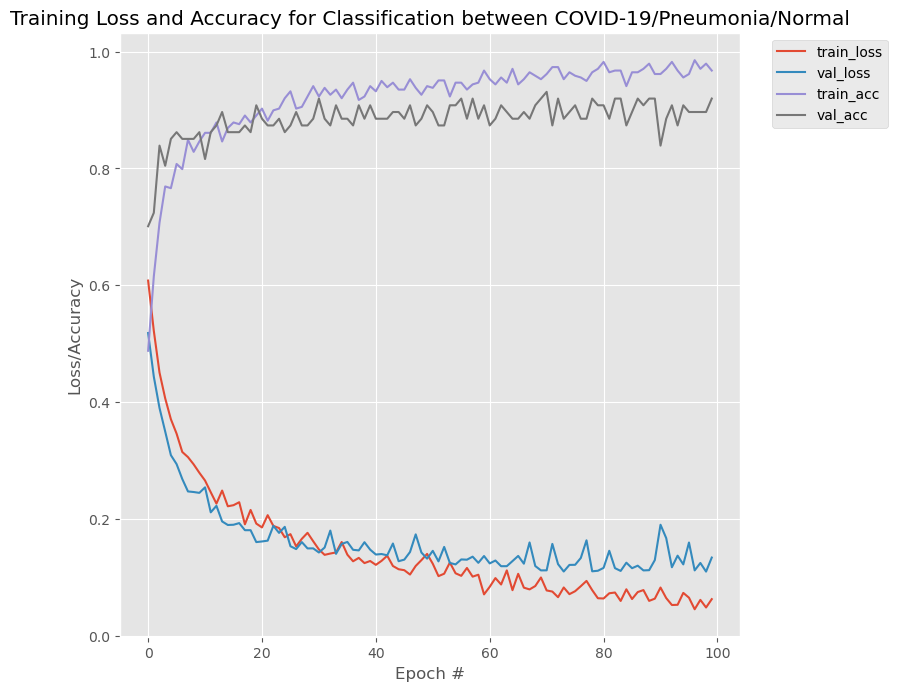

In [22]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), training.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), training.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), training.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy for Classification between COVID-19/Pneumonia/Normal")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot.png")

## Evaluting the model

In [23]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb_encoder.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      0.93      0.96        28
      normal       0.85      1.00      0.92        29
   pneumonia       0.93      0.83      0.88        30

    accuracy                           0.92        87
   macro avg       0.93      0.92      0.92        87
weighted avg       0.93      0.92      0.92        87



In [24]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the accuracy, sensitivity, and specificity of the test
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


accuracy: 0.6322
sensitivity: 1.0000
specificity: 1.0000


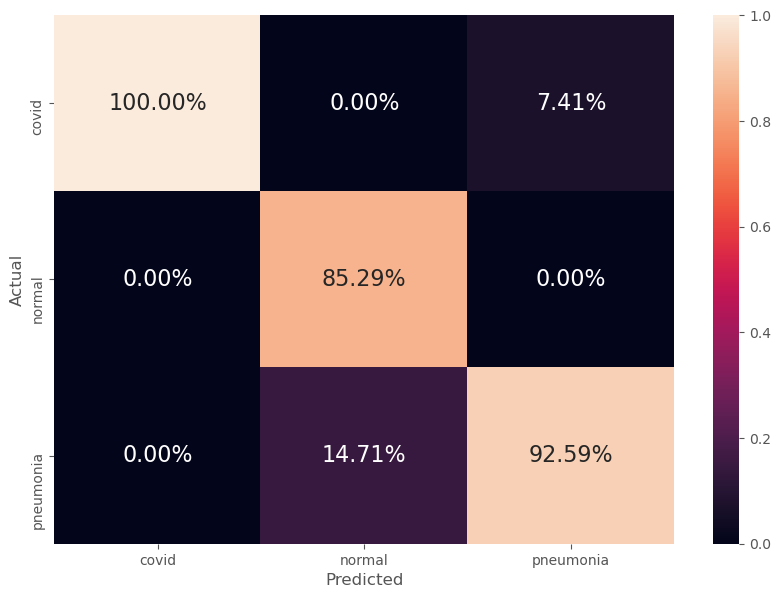

In [25]:
df_cm= pd.DataFrame(cm, columns=lb_encoder.classes_, index=lb_encoder.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(df_cm/np.sum(df_cm), fmt='.2%', annot = True, annot_kws={'size':16})
plt.show()

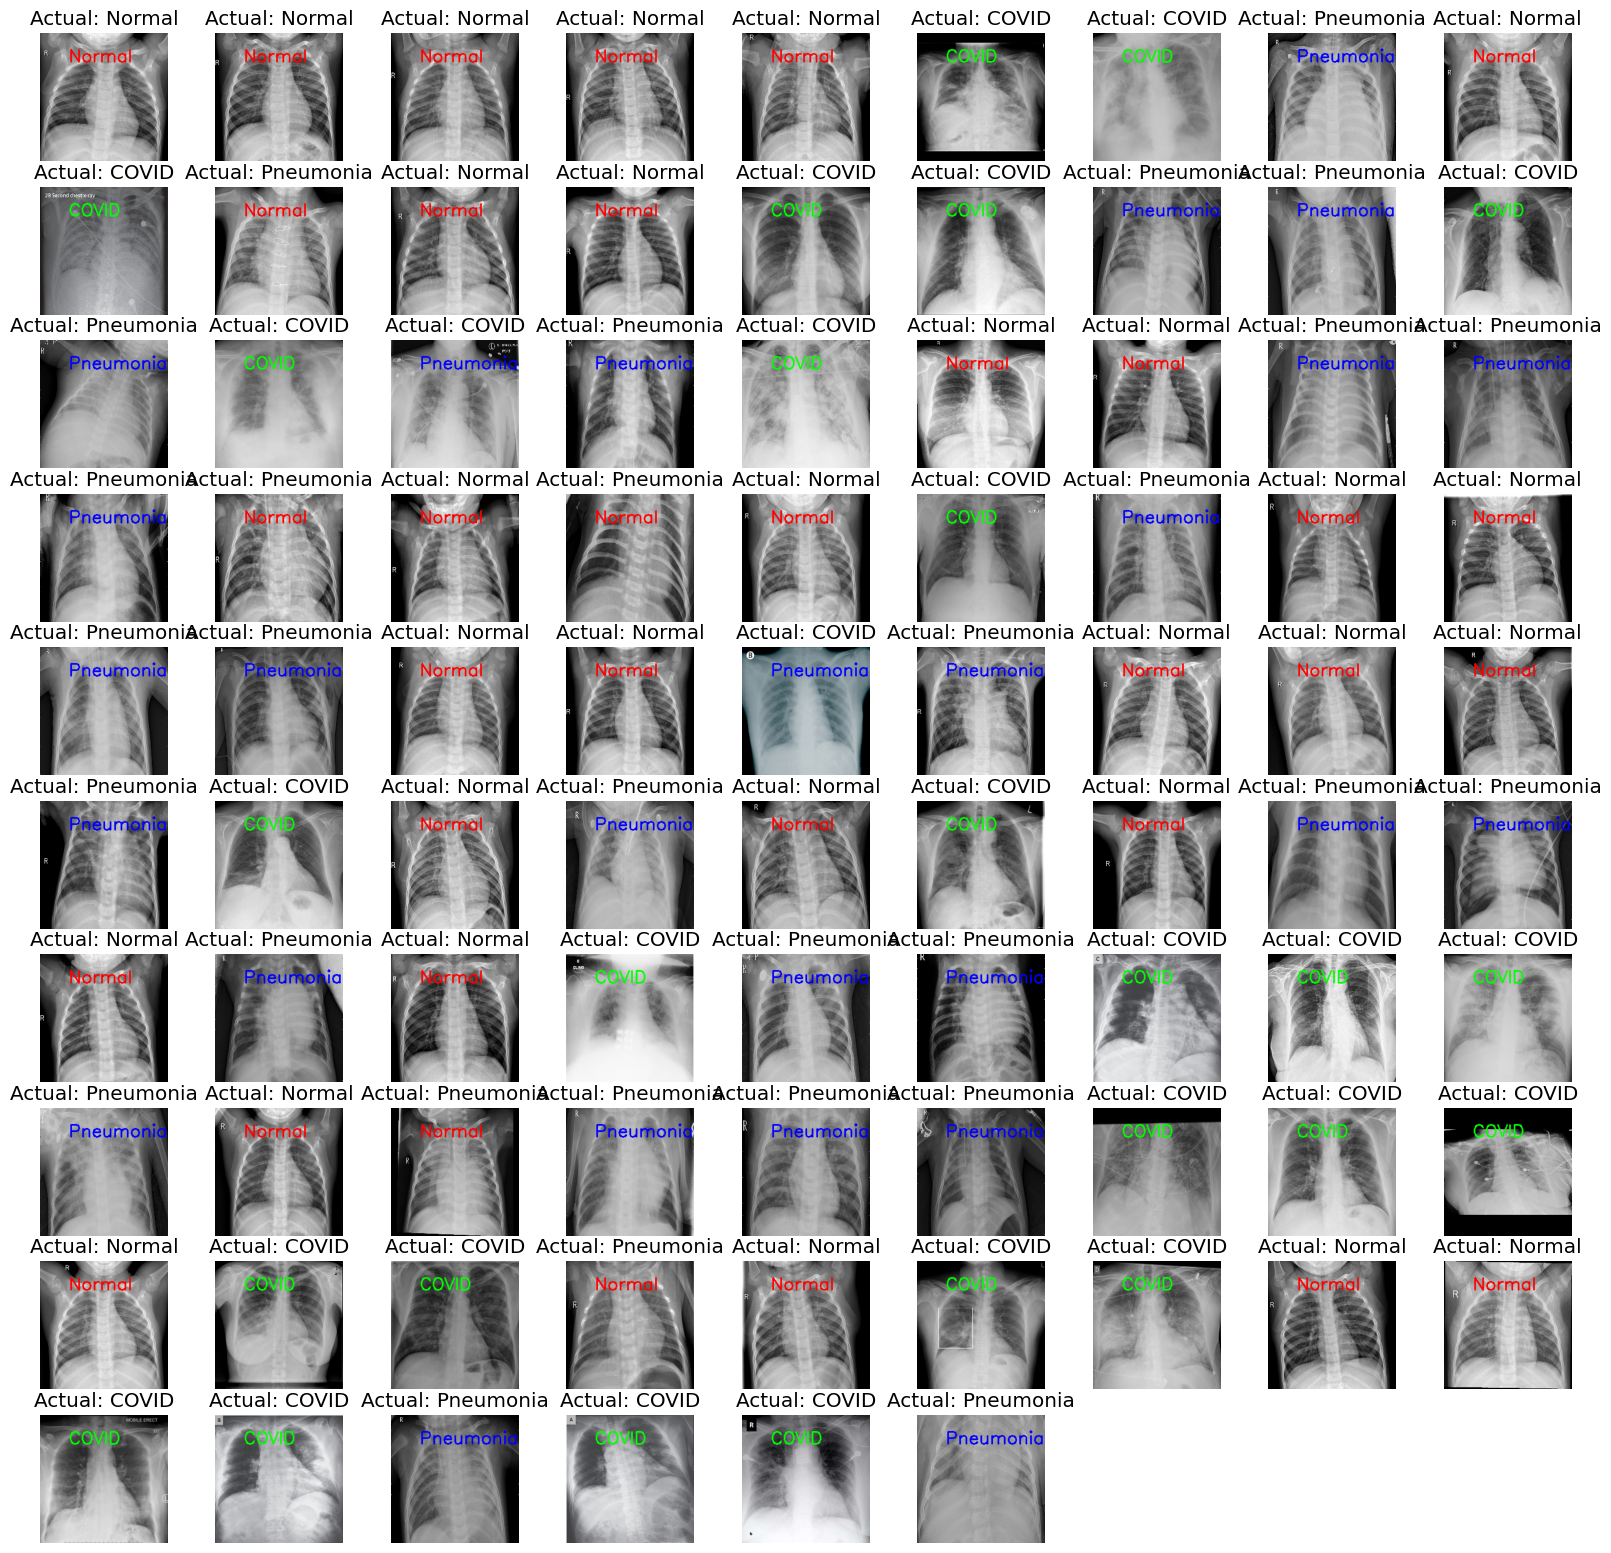

In [26]:
rows = 10
columns = 9
fig = plt.figure(figsize=(20, 20))
for m in range(1, 88):
    if str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "covid":
        text = "COVID"
        color = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
        
    if str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "covid":
        text2 = "COVID"
        color2 = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "normal":
        text2 = "Normal"
        color2 = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "pneumonia":
        text2 = "Pneumonia"
        color2 = (0, 0, 255)
    img = X_test[m-1].copy()
    # Window name in which image is displayed 
    window_name = text
  
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (50, 50) 
  
    # fontScale 
    fontScale = 1
  
    # Line thickness of 2 px 
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Actual: " + text2)
    plt.axis('off')
plt.show()

## Trying with new images in different database ("covid19-radiography-database")

In [27]:
new_dataset ='../input/covid19-radiography-database/COVID-19 Radiography Database'

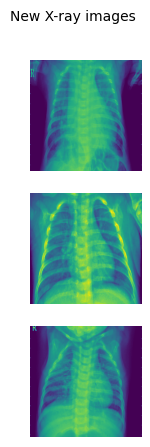

In [28]:
basePath = os.path.sep.join([new_dataset, "Viral Pneumonia"])
imagePaths = list(paths.list_images(basePath))
samples = 3

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/new", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

new_images = list(paths.list_images(f"{dataset_path}/new"))
plots_from_files(new_images, rows=3, maintitle="New X-ray images")

In [29]:
new_data = []
for imagePath in imagePaths:
    new_image = cv2.imread(imagePath)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = cv2.resize(new_image, (224, 224))
    # update the data and labels lists, respectively
    new_data.append(new_image)

new_data = np.array(new_data) / 255.0
new_data.shape

(3, 224, 224, 3)

In [30]:
# make new predictions:
print("[INFO] Making new predictions...")
new_pred = model.predict(new_data, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
new_pred = np.argmax(new_pred, axis=1)



[INFO] Making new predictions...


[INFO] printing new images with their classification


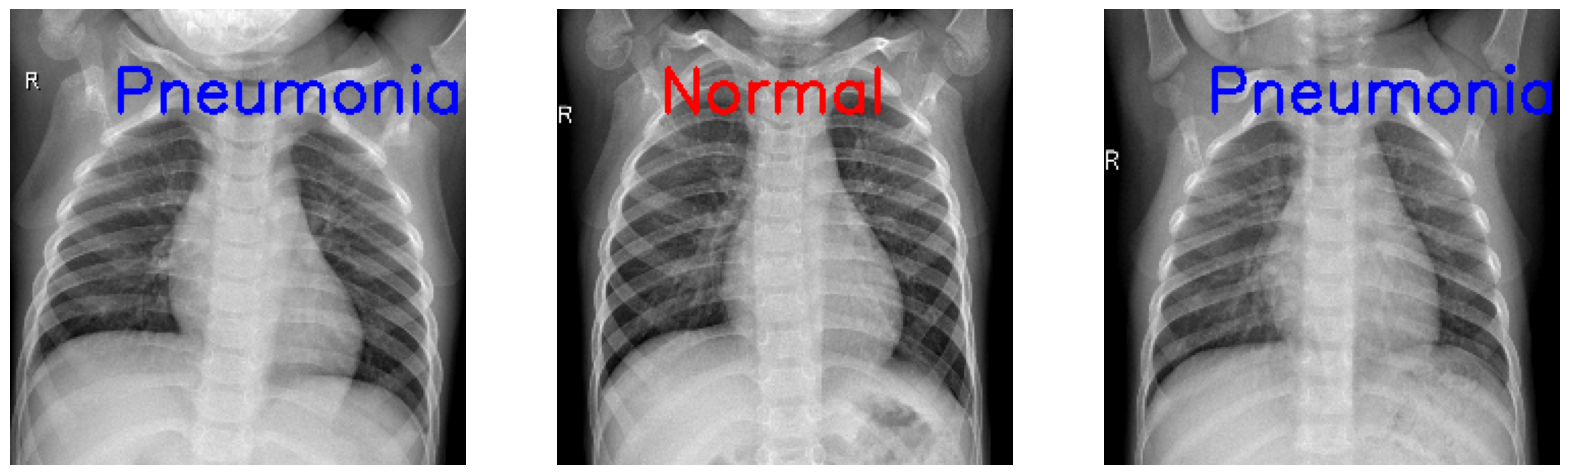

In [31]:
print("[INFO] printing new images with their classification")
rows = 1
columns = 3
fig = plt.figure(figsize=(20, 20))
for m in range(1, 4):
    if str(lb_encoder.inverse_transform(new_pred)[m-1]) == "covid":
        text = "COVID"
        color = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(new_pred)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(new_pred)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
    img = X_test[m-1].copy()
    # Window name in which image is displayed 
    window_name = text
  
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (50, 50) 
  
    # fontScale 
    fontScale = 1
  
    # Line thickness of 2 px 
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.axis('off')
plt.show()

[INFO] Making new prediction...
[INFO] printing new image with its classification


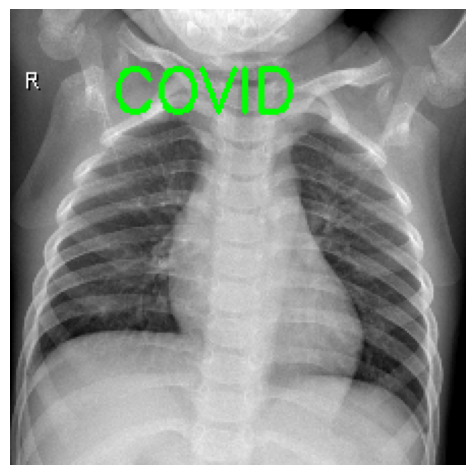

In [32]:
new_data2 = []

# Making some new testing for a specific image in the file:
new_imag2 = cv2.imread('../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/COVID-19 (10).png')
new_imag2 = cv2.cvtColor(new_imag2, cv2.COLOR_BGR2RGB)
new_imag2 = cv2.resize(new_imag2, (224,224))
new_data2.append(new_imag2)

new_data2 = np.array(new_data2)/255.0

# make new prediction
print("[INFO] Making new prediction...")
new_pred2 = model.predict(new_data2, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
new_pred2 = np.argmax(new_pred2, axis=1)

print("[INFO] printing new image with its classification")
rows = 1
columns = 3
fig = plt.figure(figsize=(20, 20))
for m in range(1, 2):
    if str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "covid":
        text = "COVID"
        color = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
    img = X_test[m-1].copy()
    # Window name in which image is displayed 
    window_name = text
  
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (50, 50) 
  
    # fontScale 
    fontScale = 1
  
    # Line thickness of 2 px 
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.axis('off')
plt.show()



In [33]:
#References
# https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/
# https://assets.researchsquare.com/files/rs-34534/v1_stamped.pdf
# https://www.sciencedirect.com/science/article/pii/S2352914820305554
# https://medium.com/saturdays-ai/detector-de-covid-19-usando-im%C3%A1genes-de-rayos-x-eaa146efa26
# https://www.kaggle.com/bachrr/detecting-covid-19-in-x-ray-images-with-tensorflow?select=images
